In [1]:
import numpy as np
import scipy as sp
import librosa as lbr
import import_ipynb
import matplotlib.pyplot as plt
from IPython.display import Audio

# Frequency and Pitch Shifting

Recall that the spectrum of a relatively stable harmonic pitch will have amplitudes of varying values across its range of harmonics. These harmonics will always be in integer multiples of the fundamental for complex tones with a single perceived pitch.

In [2]:
# Create synthesized harmonic tone on A4 = 440
t = np.linspace(0,1,44100)
f = 440
f0 = np.sin(2 * np.pi * f * t)
f1 = 0.8 * np.sin(2 * np.pi * f * t)
f2 = 0.2 * np.sin(2 * np.pi * f*2 * t)
f3 = 0.8 * np.sin(2 * np.pi * f*3 * t)
f4 = 0.15 * np.sin(2 * np.pi * f*4 * t)
f5 = 0.2 * np.sin(2 * np.pi * f*5 * t)
s = np.vstack((f0,f1,f2,f3,f4,f5)).sum(axis = 0)
s

array([ 0.00000000e+00,  3.86243447e-01,  7.58038093e-01, ...,
       -7.58038093e-01, -3.86243447e-01,  6.61968708e-13])

In [3]:
Audio(s, rate=44100)

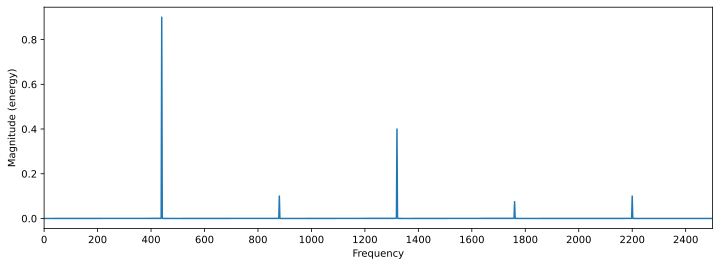

In [4]:
# Look at magnitude spectrum
plt.magnitude_spectrum(s, 44100)
plt.xlim(0,2500)
plt.xticks(np.arange(0, 2500, 200));

One way to change the frequency would be to shift everything in the frequency domain up or down, by moving the amplitude values at index $[i]$ to a new index $[i+n]$

We could achieve this by rolling (`np.roll`) the content of the magnitude spectrum forward by some amount in Hz. (Keep in mind that the `np.roll` function will move items at the end of the array to the beginning, so we would have to zero those

First, we have to actually compute a Discrete Fourier Transform (DFT) on our signal (rather than simply pass it to the plotting function). For now we will use numpy's built-in function for this.

In [9]:
X0 = np.fft.rfft(s)

In [7]:
#Roll the array to increase the pitch.
shift = 300
X1 = np.roll(X0, shift)

In [8]:
#The highest frequencies roll over to the lowest ones. That's not what we want, so zero them.
X1[0:shift] = 0

Plot old and new signal on top of each other for comparison:

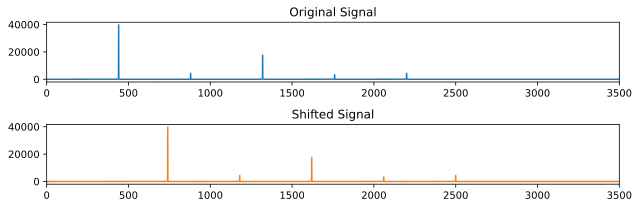

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(9, 3))

ax[0].plot(np.abs(X0))
ax[0].axis(xmin=0, xmax=3500)
ax[0].set_title('Original Signal')

ax[1].plot(np.abs(X1), color='C1')
ax[1].axis(xmin=0, xmax=3500)
ax[1].set_title('Shifted Signal')
plt.tight_layout()

To go from the frequency domain back to the time domain, we take the inverse fourier transform (iDFT). We will cover this topic in depth later. Notice the change in the sound after shifting

In [11]:
s1 = np.fft.irfft(X1)
Audio(s1, rate=44100)

As you can see, we have shifted the spectrum, but we have lost the typical relation between partials such that they are no longer an integer multiple of the fundamental. To preserve this aspect, we must multiply instead of adding in such a way as to preserve the relation between harmonics. This is the difference between **frequency** shifting, and **pitch** shifting. Pitch shifting preserves harmonic relations.

In [12]:
# take DFT of our signal (do not worry that it is using fft - more on this to come)
X = np.fft.rfft(s)

# shift_in_semitones
n = 6 

# determine frequency shift in Hz based on desired number of semitones
f = 2**(n/12)

# Decide on length N depending on whether original dft is even or odd length (more on this later)
even = (len(X) % 2 == 0)
N = len(X) // 2 + 1 if even else (len(X) + 1) // 2
Y = np.zeros(N, dtype=np.complex64)
for n in range(N):
    # move original frequency bins into scaled bins
    i_x = int(n * f)
    if i_x < N:
        Y[i_x] += X[n]
# now rebuild a symmetric DFT (i.e., copy positive to negative freq axis and flip) -- account for odd or even length
Z = np.concatenate([Y, np.conj(Y[-2:0:-1])]) if even else np.concatenate([Y, np.conj(Y[-1:0:-1])])

Compare now the output of our original signal's magnitude spectrum, X, and our pitch-shifted magnitude spectrum, Z

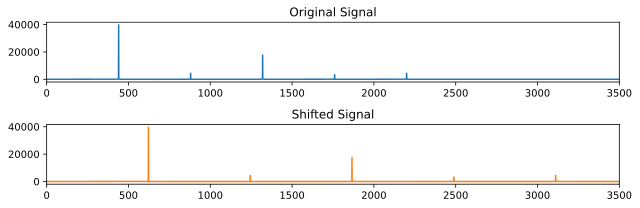

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(9, 3))

ax[0].plot(np.abs(X))
ax[0].axis(xmin=0, xmax=3500)
ax[0].set_title('Original Signal')

ax[1].plot(np.abs(Z), color='C1')
ax[1].axis(xmin=0, xmax=3500)
ax[1].set_title('Shifted Signal')
plt.tight_layout()

Notice that we have not simply slided the spectrum up, but stretched it.

In [14]:
# Take the inverse DFT of the newly built spectrum to obtain the time domain 
s2 = np.fft.irfft(Z)
Audio(s2, rate=44100)

This procedure will work for relatively stationary harmonic signals (i.e., that do not have pitch components changing over time)

In [15]:
#with real (non-synthesized) input
from scipy.io.wavfile import read
(fs, x) = read('../uploaded_audio/flute-A4.wav')
fs

44100

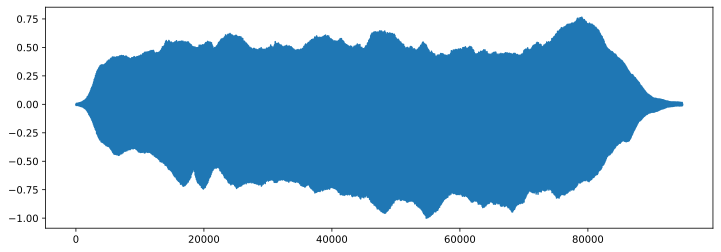

In [16]:
#normalize and plot
x = x/np.abs(x).max()
plt.plot(x)

In [17]:
Audio(x, rate=fs)

In [18]:
# take dft of signal
X = np.fft.rfft(x)

Text(0.5, 0, 'Frequency')

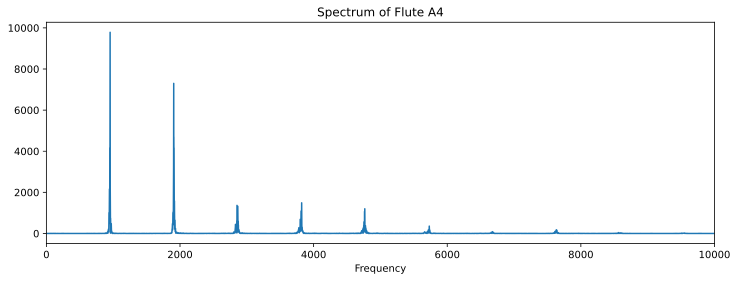

In [19]:
plt.plot(np.abs(X))
plt.xlim(0,10000)
plt.title('Spectrum of Flute A4')
plt.xlabel('Frequency')

Apply same procedure to get pitch shift

In [23]:
# take DFT of our signal (do not worry that it is using fft - more on this to come)
X = np.fft.rfft(x)

# shift_in_semitones
n = 4

# determine frequency shift in Hz based on desired number of semitones
f = 2**(n/12)

# Decide on length N depending on whether original dft is even or odd length (more on this later)
even = (len(X) % 2 == 0)
N = len(X) // 2 + 1 if even else (len(X) + 1) // 2
Y = np.zeros(N, dtype=np.complex64)
for n in range(N):
    # move original frequency bins into scaled bins
    i_x = int(n * f)
    if i_x < N:
        Y[i_x] += X[n]
# now rebuild a symmetric DFT (i.e., copy positive to negative freq axis and flip) -- account for odd or even length
Z = np.concatenate([Y, np.conj(Y[-2:0:-1])]) if even else np.concatenate([Y, np.conj(Y[-1:0:-1])])

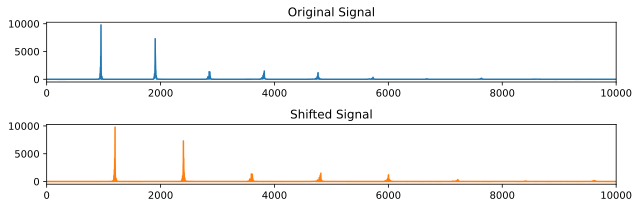

In [24]:
fig, ax = plt.subplots(2, 1, figsize=(9, 3))

ax[0].plot(np.abs(X))
ax[0].axis(xmin=0, xmax=10000)
ax[0].set_title('Original Signal')

ax[1].plot(np.abs(Z), color='C1')
ax[1].axis(xmin=0, xmax=10000)
ax[1].set_title('Shifted Signal')
plt.tight_layout()

In [25]:
# take inverse DFT
f2 = np.fft.irfft(Z)
Audio(f2, rate=44100)

In order to apply this to signals with changing pitch content over time, this procedure will not work. We would have to cut up the signal into small fragments, and pitch shift each fragment individually. (Or use an entirely different technique.) We will not get into phase vocoders here (unfortunately). If someone wants to do something more complicated than this for the midterm with pitch shifting, please see me (or check out the librosa pitch shift function).